# Import librerie

In [2]:
%reset -f
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from differential_evolution import differential_evolution

# Preparazione dati


Lettura e shuffle del dataset

In [24]:
df = pd.read_csv('/Users/raffaelerusso/Desktop/Uni/ro/RO-progetto/Dataset/drawings.csv')
df =  df.sample(frac=1, random_state=0)

Estraggo le ground label dal dataset, corrispondenti all'ultima colonna del dataframe. Converto poi i dati in un formato adatto al modello in keras

In [25]:
labels = np.float32(df.pop('label'))
pics = np.float32(df.to_numpy())
pics = np.reshape(pics,(-1,28,28))
num_classes = 10
labels = keras.utils.to_categorical(labels,num_classes)

Seleziono immagini da attaccare

In [26]:
y_att = labels[5417:]
x_att = pics[5417:]
x_att = np.expand_dims(x_att,axis=-1)

In [28]:
x_att[0].shape

(28, 28, 1)

# Caricamento e valutazione del modello

Carico modello e pesi ottenuti dall'addestramento effettuato in precedenza

In [ ]:
model = tf.keras.models.load_model('/Users/raffaelerusso/Desktop/RO-progetto/ModelloPesi/mnist_model.h5')
model.load_weights('/Users/raffaelerusso/Desktop/RO-progetto/ModelloPesi/mnist_weights.h5')


Valuto le statistiche sulle immagini da attaccare

In [47]:
result = model.evaluate(x_att,y_att)
test_acc = result[1]
test_loss = result[0]

print('Accuracy pre-attacco : ',test_acc)
print('Loss pre-attacco : ',test_loss)

100/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

# Preparazione attacco avversario


Import funzioni necessarie per l'attacco:

Funzione per generare le immagini perturbate a partire dal vettore delle perturbazioni

In [48]:
def perturb_image(xs, img):
    # Controllo se il numero di pixel perturbati è pari solo a uno e in tal caso
    # lo trasformo in una lista per lasciare inalterato il calcolo
    if xs.ndim < 2:
        xs = np.array([xs])
       
    #Copio l'immagine immagine  n == len(xs) volte per creare n immagini perturbate(inutilizzato)
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)
   
    # La perturbazione deve essere intera
    xs = xs.astype(int)
    
    for x,img in zip(xs, imgs): #ottengo (vettore_perturbazioni x - immagine da perturbare(qui una))

        # Split di x in un'array di 3 elementi ciascuno, ossia per la singola perturbazione 
        # i.e [[x,y,z], ...]
        pixels = np.split(x, len(x) // 3) 
        for pixel in pixels:
            #A ogni pixel (x,y) assegno il suo livello di grigio z
            x_pos, y_pos, *gray = pixel  #[x,y,z]
            img[x_pos, y_pos] = gray
    
    return imgs

La funzione costo da minimizzare passata a differential evolution, che restituisce il livello di confidenza associato alla classe corretta(target)

In [49]:
def predict_classes(xs, img, target_class, model):
    imgs_perturbed = perturb_image(xs, img)
    predictions = model.predict(imgs_perturbed)[:,target_class]
    return predictions 

Funzione ausiliaria, passata a differential evolution, come criterio di successo. In particolare l'algoritmo termina quando la classe predetta dell'immagine perturbata non coincide più con la classe target, ossia la classe corretta

In [50]:
def attack_success(x, img, target_class, model, targeted_attack=False, verbose=False):
    attack_image = perturb_image(x, img)

    confidence = model.predict(attack_image)[0]
    predicted_class = np.argmax(confidence)

    if verbose:
        print('Confidence:', round(confidence[target_class],ndigits=3))
    if ((targeted_attack and predicted_class == target_class) or
        (not targeted_attack and predicted_class != target_class)):  
        return True 

Funzione d'attacco

In [51]:
def attack(img_id, model, target=None, pixel_count=1, 
           maxiter=75, popsize=400, verbose=False):
    # Seleziono la classe target a seconda che l'attacco sia targeted o untargeted 
    targeted_attack = target is not None
    target_class = target if targeted_attack else int(y_att[img_id])
    
    # Definisco vettore perturbazione
    bounds = [(0,28), (0,28), (0,2)] * pixel_count
    
    # Moltiplicatore della popolazione a seconda della dimensione del vettore di perturbazione
    popmul = max(1, popsize // len(bounds))
    
    img = x_att[img_id]
    img = np.reshape(img,(1,28,28,1))
    
    # Funzioni ausiliarie per l'algoritmo evoluzione differenziale
    def predict_fn(xs): #nella forma f(x,args) dove x è un vettore 1d 
        return predict_classes(xs, img, target_class, 
                               model)
    
    def callback_fn(x, convergence): #quando ritorna True l'algoritmo termina
        return attack_success(x, img, target_class, 
                              model, targeted_attack, verbose)
    
    #Differential Evolution
    attack_result = differential_evolution(predict_fn, bounds, maxiter=maxiter, popsize= popmul,mutation=1,recombination = 1, atol = -1, callback=callback_fn, polish=False)

    
    # Calcolo statistiche
    attack_image = perturb_image(attack_result.x, img)[0]
    prior_probs = model.predict(img)
    
    attack_image = np.reshape(attack_image,(1,28,28,1))
    predicted_probs = model.predict(attack_image)
  
    predicted_class = np.argmax(predicted_probs)
    actual_class = int(y_att[img_id])
    success = predicted_class != actual_class
    
    return [attack_image, pixel_count, img_id, actual_class, predicted_class, success, prior_probs, predicted_probs, attack_result.x]
   

# Generazione Attacco Avversario

Converto y_att in modo che sia compatibile con la funzione d'attacco

In [52]:
y_att =np.reshape(np.argmax(y_att,1),(len(x_att[:]),1))

Scelgo i parametri per l'attacco e salvo i risultati relativi a ogni immagini nella lista results

In [53]:
pixels = 20
results = []

for i in range(len(x_att[:])):
  result =  attack(i, model, pixel_count=pixels,maxiter=100,popsize=100,target = None, verbose=False)
  results.append(result)

/Users/raffaelerusso/Desktop/RO-progetto/Codice/differential_evolution.py:586: RuntimeWarning: divide by zero encountered in double_scalars
  


# Prestazioni attacco


Converto x_att e results in due array numpy
 

In [58]:
x_attk = np.array(x_att)
results_arr = np.array(results)

/Users/raffaelerusso/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Salvataggio delle immagini attaccate e delle relative classi predette dal modello dopo l'attacco

In [59]:
pics_att = np.zeros(shape = (100,28,28,1))
preds_att = np.zeros(shape = (100,1))

for i in range(len(results)):
    pics_att[i] = results[i][0]
    preds_att[i] = results[i][4]

Valutazione dei parametri di accuratezza e funzione loss precedentemente e successivamente all'attacco appena eseguito

In [60]:
y_att = labels[5417:]

score_pre_att = model.evaluate(x_att,y_att)
acc_pre_att = score_pre_att[1]
loss_pre_att = score_pre_att[0]

score_post_att = model.evaluate(pics_att,y_att)
acc_post_att = score_post_att[1]
loss_post_att = score_post_att[0]

print('test_acc: Pre ',acc_pre_att, ' After: ',acc_post_att)
print('test_loss: Pre ',loss_pre_att,' After: ',loss_post_att)

100/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Salvataggio del vettore dei risultati

In [ ]:
#np.save('/content/drive/MyDrive/RO-progetto/CR=1_F=1/pixels20',results)

Caricamento dei risultati relativi ad un attacco

In [ ]:
#f = np.load('/content/results_50pixels_50it.npy',allow_pickle=True)

Visualizzazione dell'immagine pre e post attacco con le relative etichette predette dal modello \
Salvataggio finale delle immagini

/Users/raffaelerusso/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


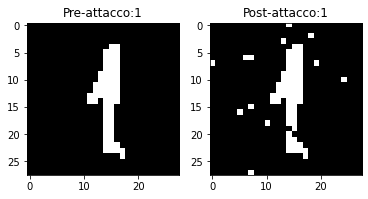

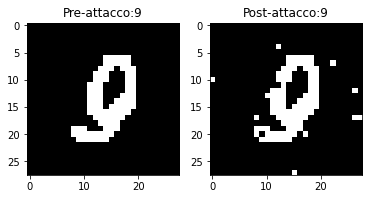

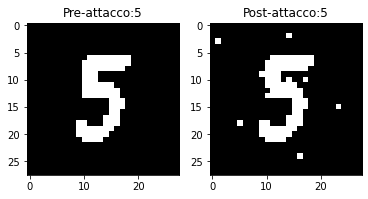

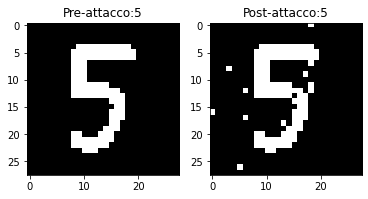

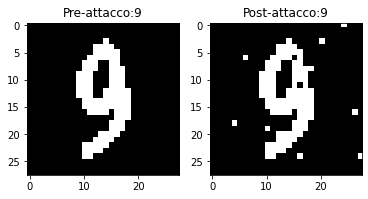

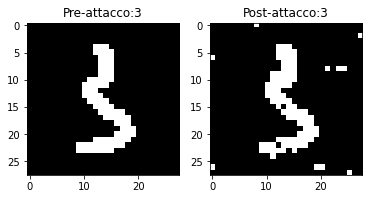

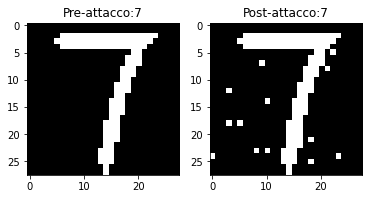

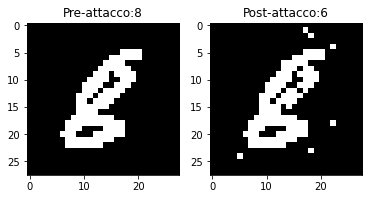

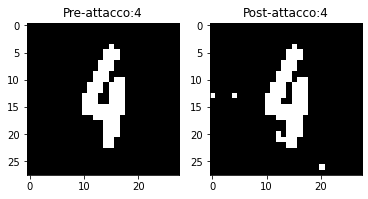

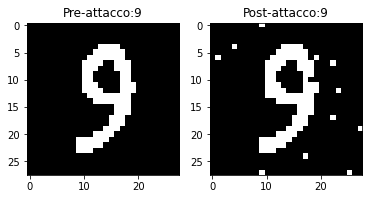

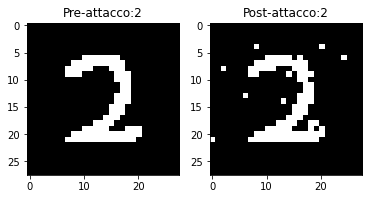

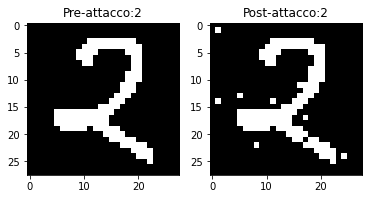

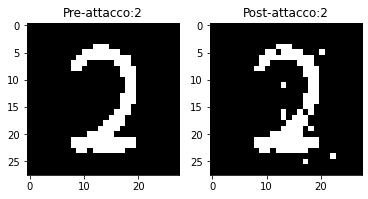

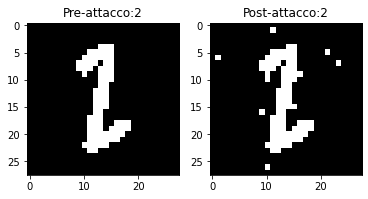

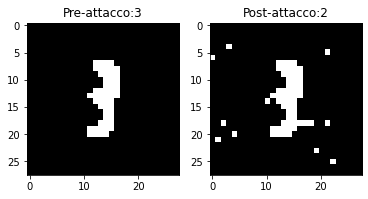

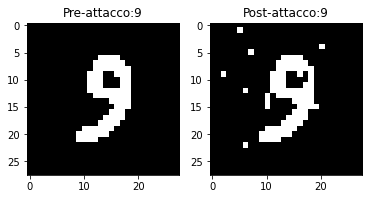

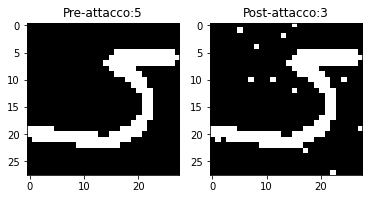

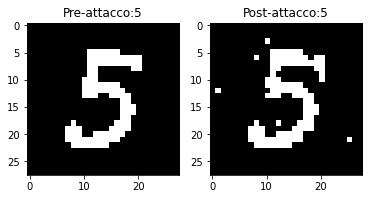

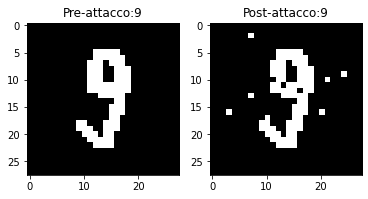

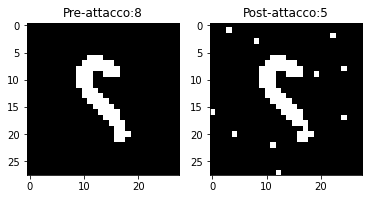

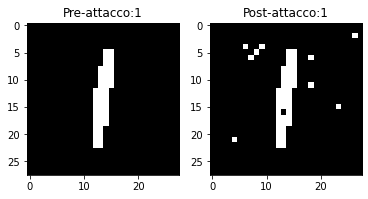

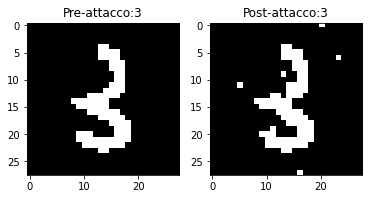

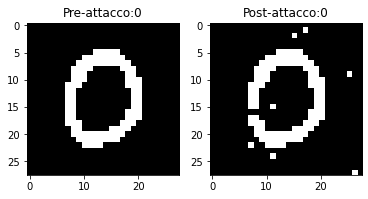

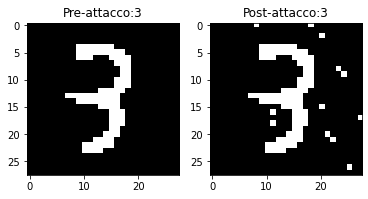

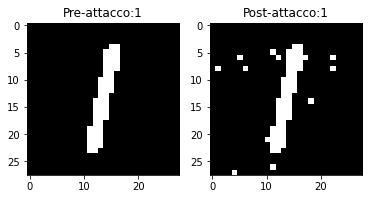

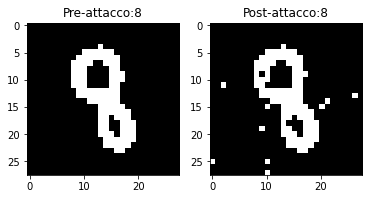

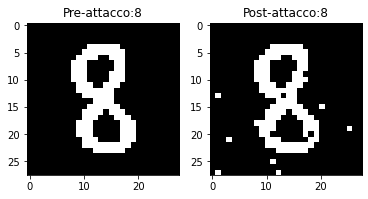

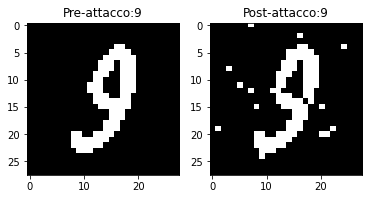

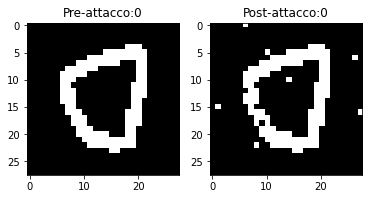

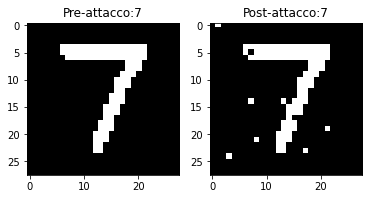

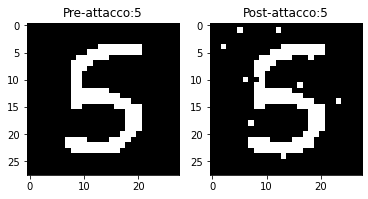

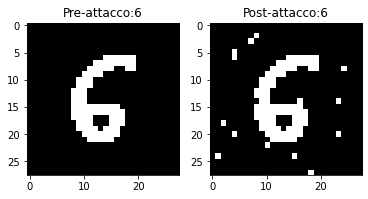

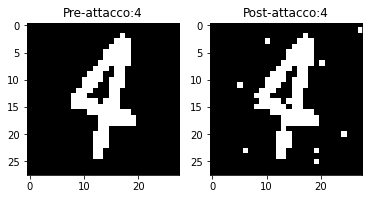

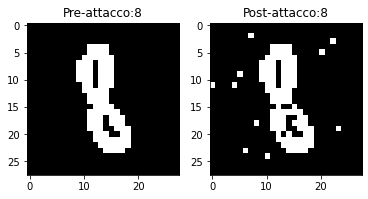

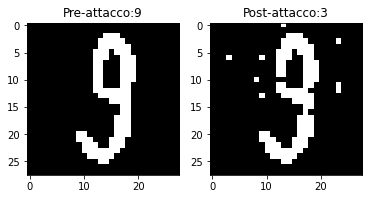

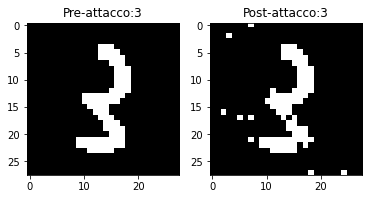

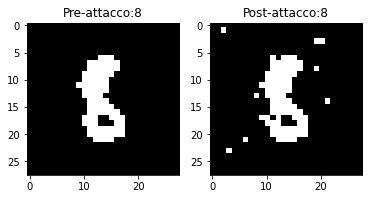

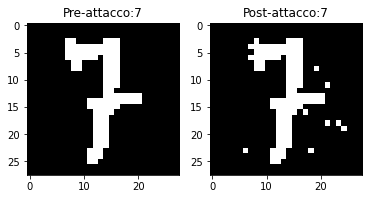

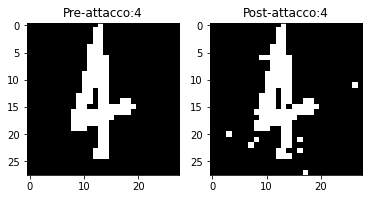

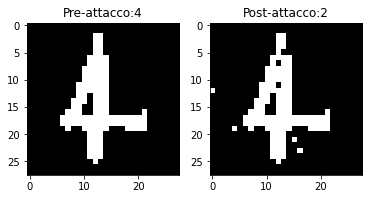

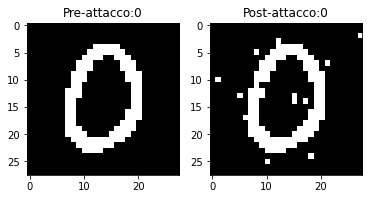

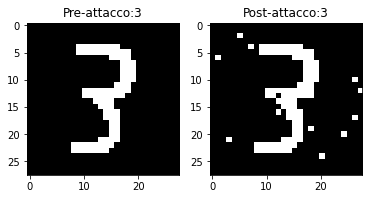

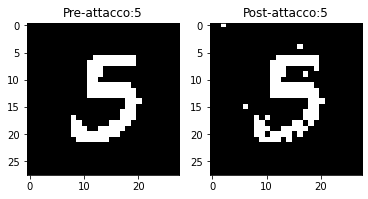

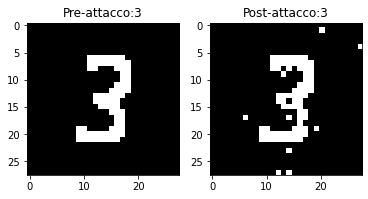

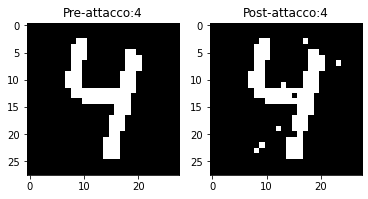

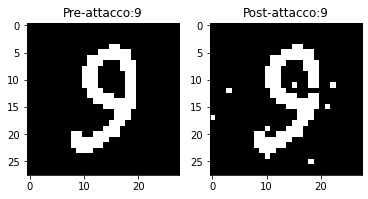

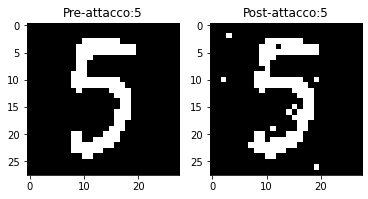

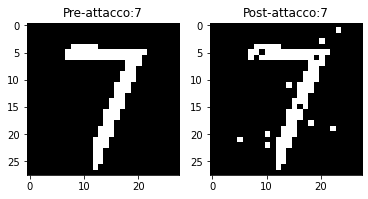

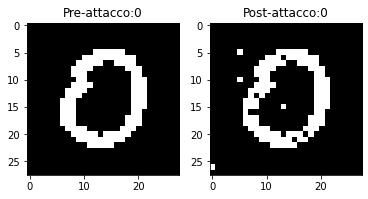

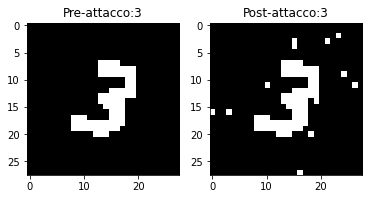

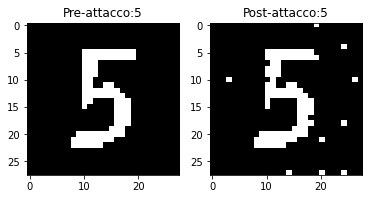

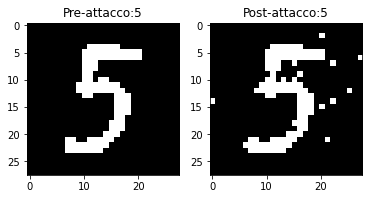

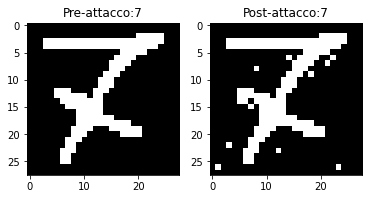

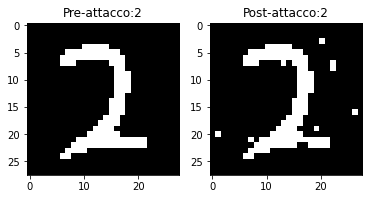

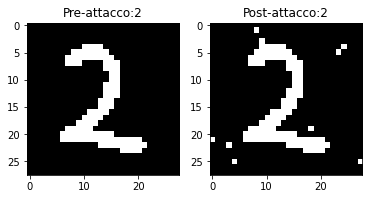

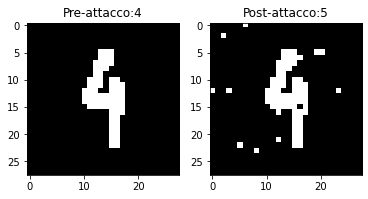

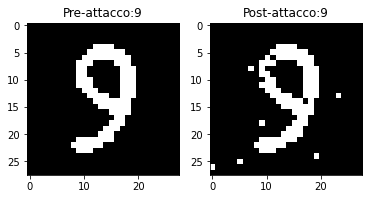

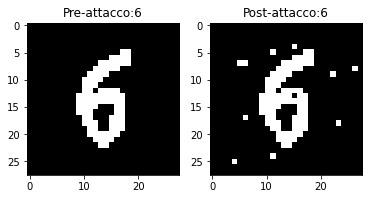

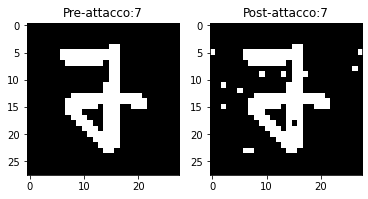

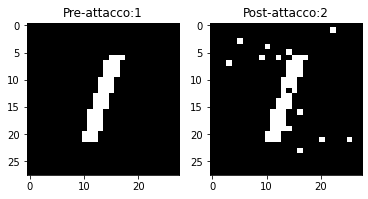

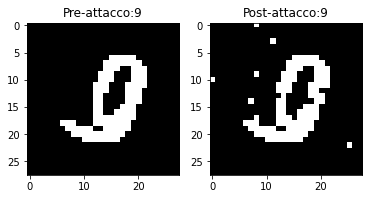

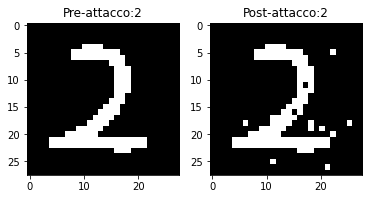

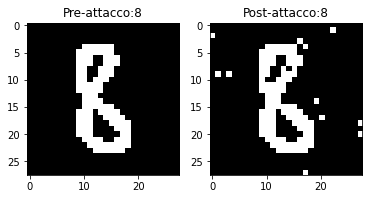

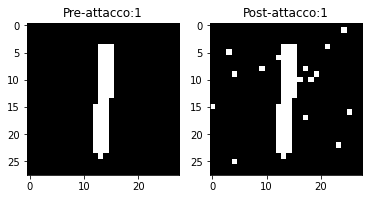

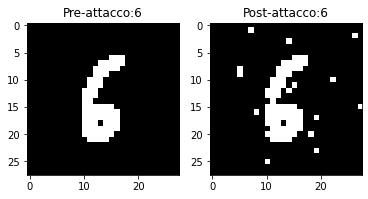

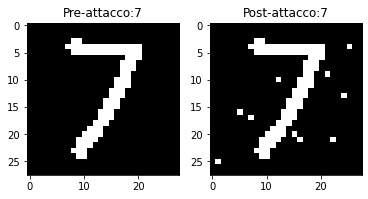

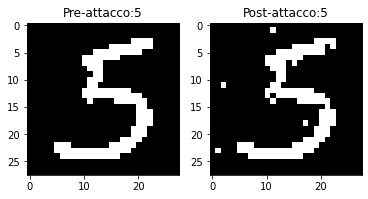

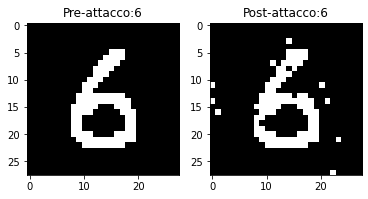

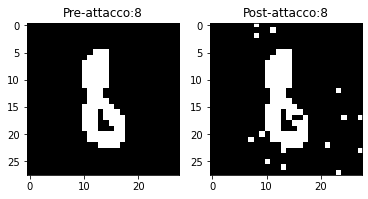

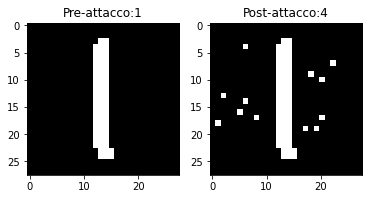

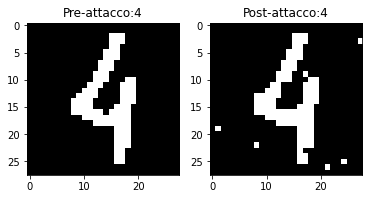

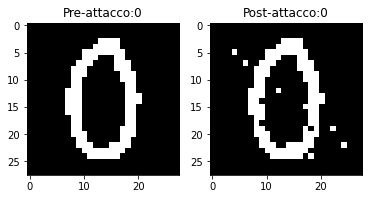

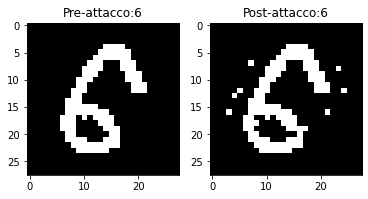

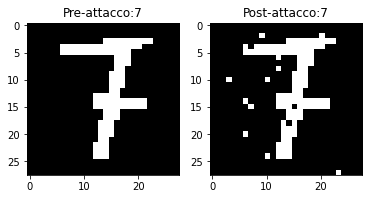

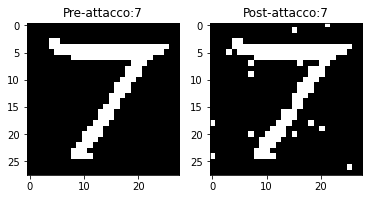

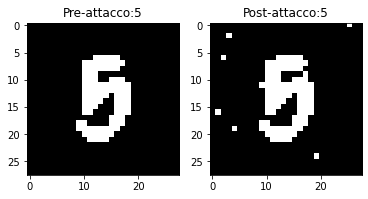

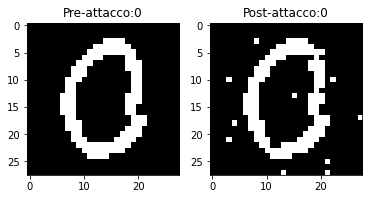

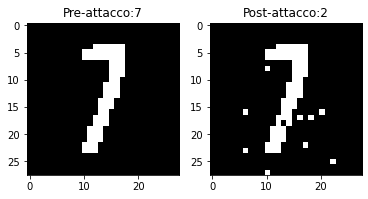

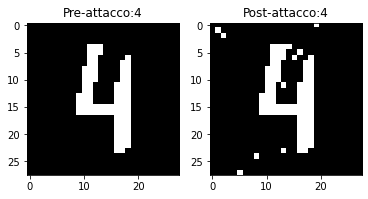

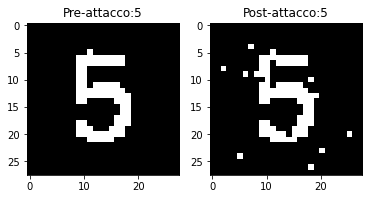

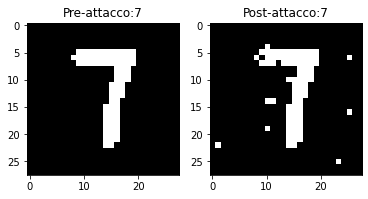

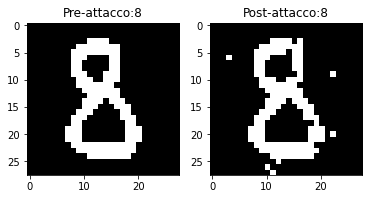

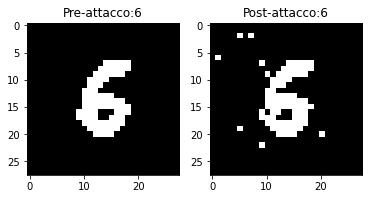

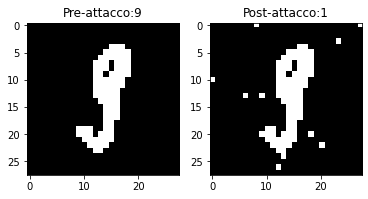

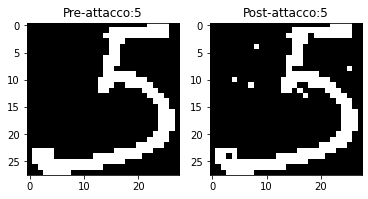

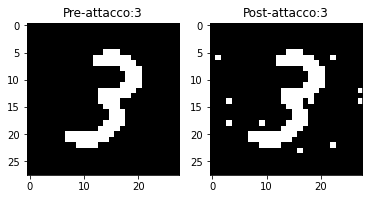

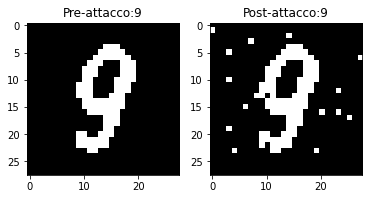

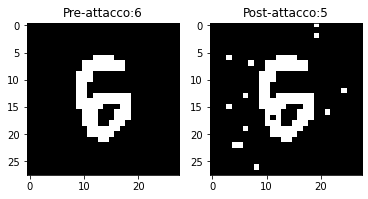

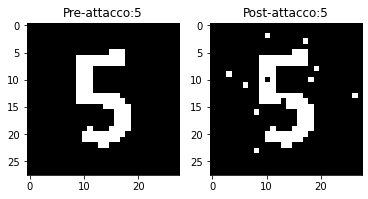

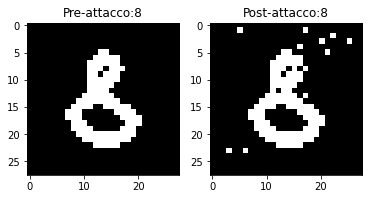

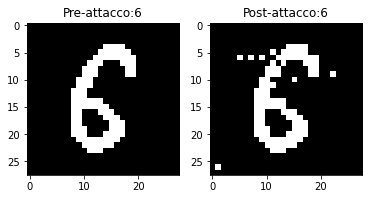

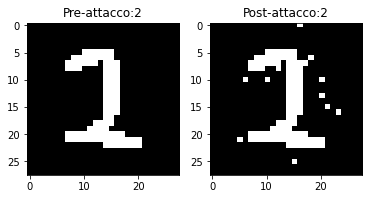

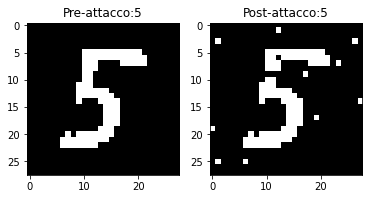

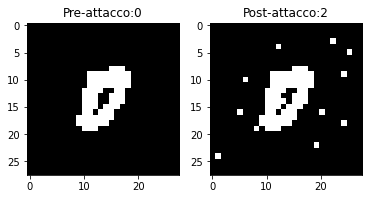

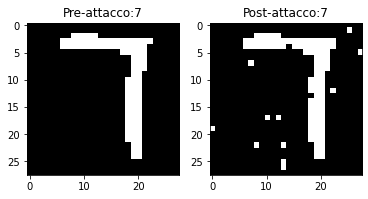

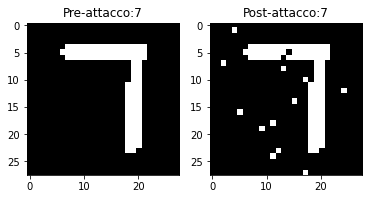

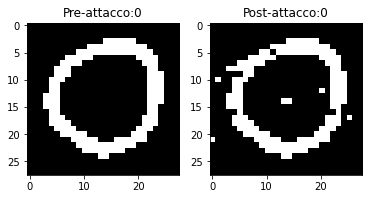

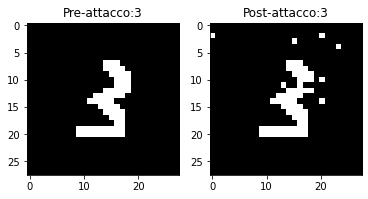

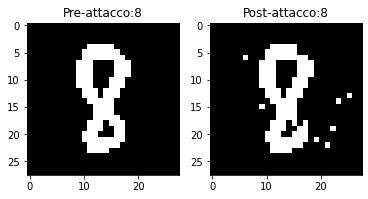

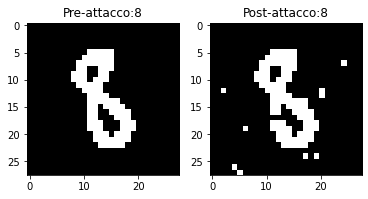

In [61]:
for i in range(len(results)):
  plt.figure()
  plt.subplot(1,2,1)
  plt.title('Pre-attacco:' + str(np.argmax(y_att[i],axis=-1)))
  plt.imshow(np.reshape(x_att[i],(28,28)),clim = [0,1],cmap = 'gray')
  plt.subplot(1,2,2)
  plt.title('Post-attacco:' + str(int(preds_att[i][0])))
  plt.imshow(np.reshape(pics_att[i],(28,28)),clim = [0,1],cmap = 'gray')
  #plt.savefig('/content/drive/MyDrive/RO-progetto/CR=1_F=1/pixels20/'+str(i))